# Computing Fiber Diffraction Patterns

![im](setup.png "Setup")

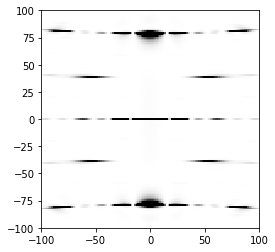

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# The atomic number of the unique atoms in the structure
atomic_number = {'C': 6, 'N': 7, 'O': 8}

def Rx(angle_deg):
    """Rotation matrix around x"""

    angle_rad = angle_deg/180.0*np.pi
    return np.array([[1, 0, 0],
                     [0, np.cos(angle_rad), -np.sin(angle_rad)],
                     [0, np.sin(angle_rad), np.cos(angle_rad)]])

def Ry(angle_deg):
    """Rotation matrix around y"""

    angle_rad = angle_deg/180.0*np.pi
    return np.array([[np.cos(angle_rad), 0, np.sin(angle_rad)],
                     [0, 1, 0],
                     [-np.sin(angle_rad), 0, np.cos(angle_rad)]])

def Rz(angle_deg):
    """Rotation matrix around z"""

    angle_rad = angle_deg/180.0*np.pi
    return np.array([[np.cos(angle_rad), -np.sin(angle_rad), 0],
                     [np.sin(angle_rad), np.cos(angle_rad), 0],
                     [0, 0, 1]])


def helix_maker(hexad_atoms, hexad_coord, rise, twist, num_hexads):
    """ A function to generate a stacked hexad structure given the
        rise, twist, and the number of hexad units"""

    coord = []
    atoms = np.array([i for i in hexad_atoms]*num_hexads) # Replicate the atom names
    # Loop over the number of hexads
    for i in range(num_hexads):
        # Loop over all atoms in the hexad
        for j in range(len(hexad_coord)):
            x = hexad_coord[j, 0]
            y = hexad_coord[j, 1]
            z = hexad_coord[j, 2] + i*rise # Apply the rise
            c = np.dot(Rz(twist*i), np.array([x, y, z])) # Apply the twist
            coord.append(c)

    return atoms, np.array(coord)

def save_xyz(atoms, coord, file_name):
    """ A function to write an XYZ file given the atom names and coordinates"""

    out = open(file_name, 'w')
    out.write('%i\n\n' %len(atoms))
    for i in range(len(atoms)):
        out.write('%-6s%12.6f%12.6f%12.6f\n' %(atoms[i], coord[i, 0], coord[i, 1], coord[i, 2]))
    out.close()

def generate_fiber_diffraction(atoms, coord, wavelength, distance_to_detector,
                               z_grid_limits, x_grid_limits, z_grid_size, x_grid_size, max_intensity_scaling):
    """ A function to generate the fiber diffraction pattern
    """

    # Determine the resolution of the grid
    # The limits of the grid are -100 to 100 mm in the x and z axes
    z_range = np.linspace(z_grid_limits[0], z_grid_limits[1], z_grid_size)
    x_range = np.linspace(x_grid_limits[0], x_grid_limits[1], x_grid_size)

    out = np.zeros((z_grid_size, x_grid_size)) # Store the intensities here
    # Loop over the z-axis points
    for i, z in enumerate(z_range):
        # Loop over the x-axis points
        for j, x in enumerate(x_range):
            # Compute the distance of all the atoms from the detector
            # The detector lies at the y-axis
            # The light wave is given as: A*exp(i k.r), where i is the imaginary unit,
            # k is the wave vector (2*pi/lambda) and r is the distance.
            # Use Euler's formula to get it in terms of sin and cos.
            # Use the atomic numbers as scattering factors
            dist = coord[:, 1] + np.sqrt((x + coord[:, 0])**2 + (distance_to_detector - coord[:, 1])**2
                                         + (z + coord[:, 2])**2)
            s  = np.sum(atoms * np.cos(2*np.pi/wavelength*dist)) * np.complex(1, 0)
            s += np.sum(atoms * np.sin(2*np.pi/wavelength*dist)) * np.complex(0, 1)
            out[i, j] = (s * np.conj(s)).real # Multiply by the complex conjugate to get the intensity
            
    # Plot the diffraction pattern using a gray color map
    # To prevent the disappearance of low intensity peaks, we limit the
    # color map  to the maximum intensity multiplied by a specified factor
    plt.imshow(out, extent=(np.min(x_range), np.max(x_range), np.min(z_range), np.max(z_range)),
               cmap='gray_r', vmax=np.max(out)*max_intensity_scaling)
    plt.show()


# An xyz file containing the atomic coordinates
# In this example, we provide the coordinates of one triaminopyrimidine and cyanuric acid hexad unit
coordinates_file = 'hexad.xyz'

# Specify the rise and twist values to make the helical hexad
rise = 3.4 # Angstroms
twist = 30 # Degrees
number_of_hexads = 50 # The number of hexads in the stacks
output_file_name = 'fiber.xyz' # Save the generated geometry to this file

# Specify the fiber diffraction parameters
wavelength = 0.7749e-7 # The wavelength of the light beam in mm
distance_to_detector = 338.4 # The y-axis distance to the detector in mm
z_grid_limits = [-100.0, 100.0] # The limits of the grid along the z-axis in mm
x_grid_limits = [-100.0, 100.0] # The limits of the grid along the x-axis in mm
z_grid_size = 129 # The resolution of the grid along the z-axis
x_grid_size = 129 # The resolution of the grid along the x-axis
max_intensity_scaling = 0.01 # A scale factor to limit the maximum intensity in the diffraction plot

# Read the atomic coordinates
coords = np.loadtxt(coordinates_file, usecols=(1, 2, 3), skiprows=2)
atoms = np.loadtxt(coordinates_file, usecols=(0,), skiprows=2, dtype='str')

# Make a hexad helix; comment out if not using a hexad system
atoms, coords = helix_maker(atoms, coords, rise, twist, number_of_hexads)
save_xyz(atoms, coords, output_file_name)

# Update coordinates and atomic numbers
coords *= 1e-7 # Convert from Angstroms to mm
atomic_numbers = [atomic_number[a] for a in atoms] # Convert from elements to atomic numbers

# Generate the fiber diffration
generate_fiber_diffraction(atomic_numbers, coords, wavelength, distance_to_detector, 
                           z_grid_limits, x_grid_limits, z_grid_size, x_grid_size, max_intensity_scaling)